# Investigating the functions


In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_5/initial_inputs.npy")
f1_out = np.load("./../function_5/initial_outputs.npy")
f1_out

file2_inp = np.load("./../../initial_data2/function_5/initial_inputs.npy")
file2_out = np.load("./../../initial_data2/function_5/initial_outputs.npy")

f1_inp = np.concatenate((f1_inp, file2_inp))
f1_out = np.concatenate((f1_out, file2_out))

q1_inp = [0.738478, 0.341978, 0.497678, 0.402775]
q1_out = [3.228204336981543]

q2_inp = [0.128449, 0.9925  , 0.940784, 0.969227]
q2_out = [3268.4855601851705]

q3_inp = [0.04594 , 0.981325, 0.974149, 0.999988]
q3_out = [3863.2718555739757]

q4_inp = [0.073603, 0.960833, 0.96323 , 0.999998]
q4_out = [3500.7228326026247]

q5_inp = [0.015508, 0.986277, 0.99961 , 0.94283]
q5_out = [3567.6116420218964]


f1_inp = np.vstack((f1_inp, q1_inp, q2_inp, q3_inp,q4_inp, q5_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out,q4_out,q5_out])
f1_inp, f1_out
max(f1_out) , min(f1_out), np.mean(f1_out)

(3863.2718555739757, 0.1129397953712203, 568.2119389862933)

In [68]:
# toptop
f1_inp, f1_out

(array([[0.19144708, 0.03819337, 0.60741781, 0.41458414],
        [0.75865295, 0.53651774, 0.65600038, 0.36034155],
        [0.43834987, 0.8043397 , 0.21024527, 0.15129482],
        [0.70605083, 0.53419196, 0.26424335, 0.48208755],
        [0.83647799, 0.19360965, 0.6638927 , 0.78564888],
        [0.68343225, 0.11866264, 0.82904591, 0.56757661],
        [0.55362148, 0.66734998, 0.32380582, 0.81486975],
        [0.35235627, 0.32224153, 0.11697937, 0.47311252],
        [0.15378571, 0.72938169, 0.42259844, 0.44307417],
        [0.46344227, 0.63002451, 0.10790646, 0.9576439 ],
        [0.67749115, 0.35850951, 0.47959222, 0.07288048],
        [0.58397341, 0.14724265, 0.34809746, 0.42861465],
        [0.30688872, 0.31687813, 0.62263448, 0.09539906],
        [0.51114177, 0.817957  , 0.72871042, 0.11235362],
        [0.43893338, 0.77409176, 0.37816709, 0.93369621],
        [0.22418902, 0.84648049, 0.87948418, 0.87851568],
        [0.72526172, 0.47987049, 0.08894684, 0.75976022],
        [0.355

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.
- Prior Knowledge: One of the features might not impact the outcome, consider to remove it


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [2]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

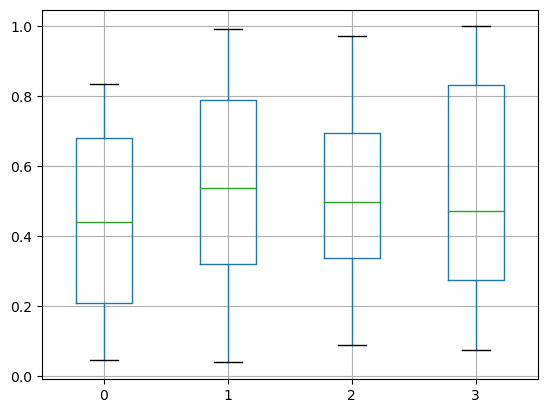

In [4]:
## Checking for outliers

pd_inp.boxplot() # OUTLIER DEDECTED ON THE 3RD FEATURE OF INPUTS
plt.show()

<Axes: >

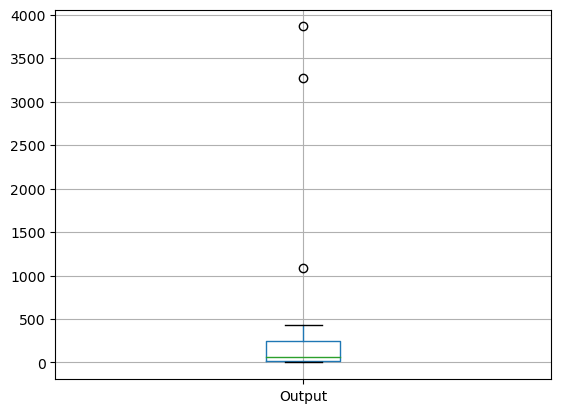

In [5]:
pd_out.boxplot() 

## Distribution 

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

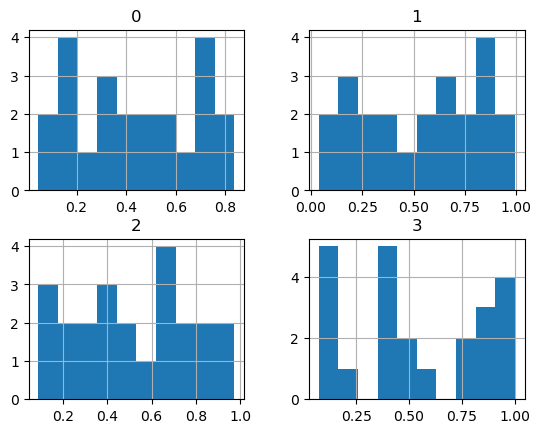

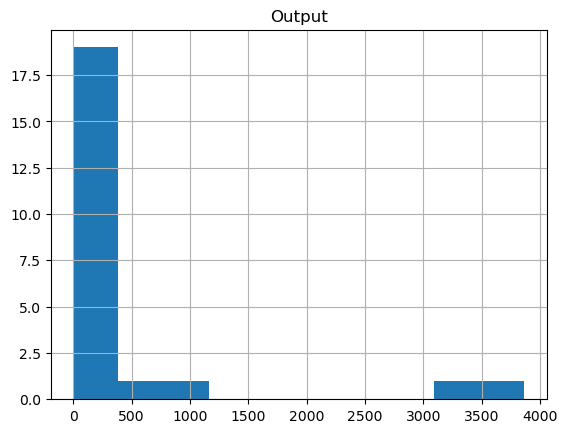

In [6]:
pd_inp.hist(), pd_out.hist()

In [7]:
skew(f1_inp),skew(f1_out)


#np.var(f1_inp),np.var(f1_out)

(array([-0.03614509, -0.10899494, -0.00943892,  0.02124797]),
 2.727552885844854)

In [8]:
# Distribution affected by outlier 

# Input/Output Relationship Analysis 

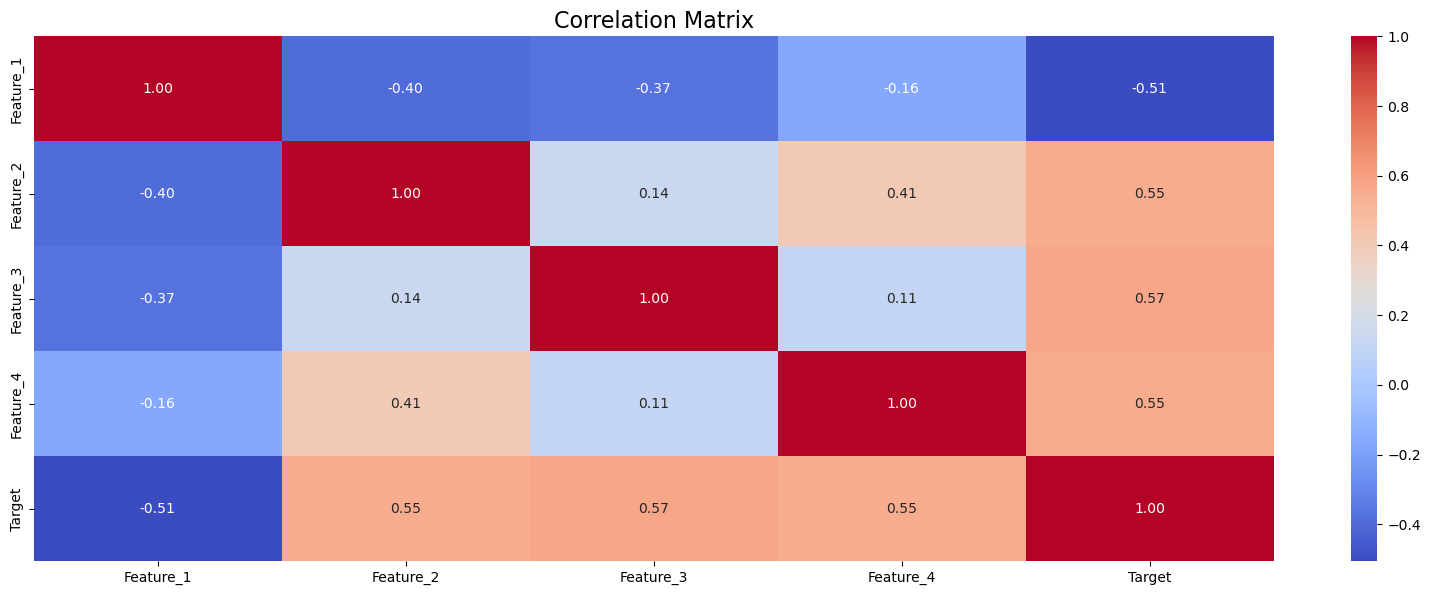

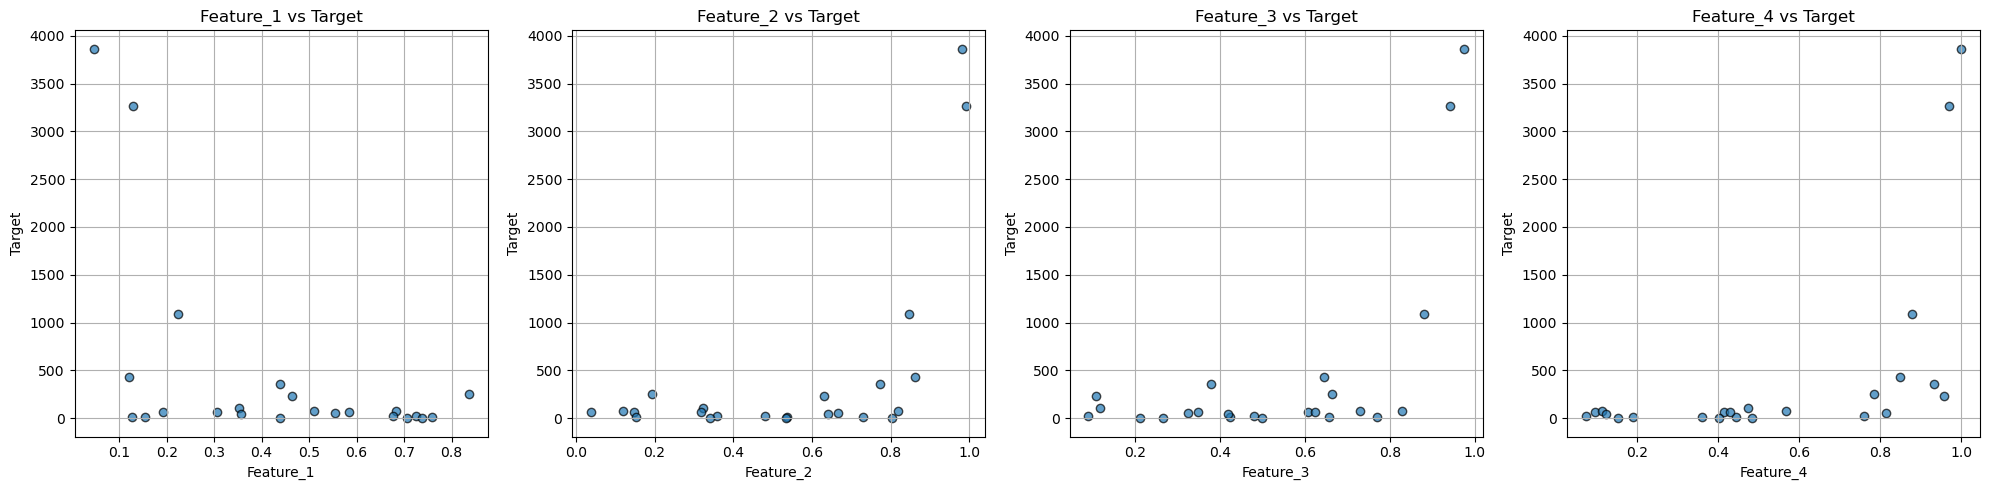

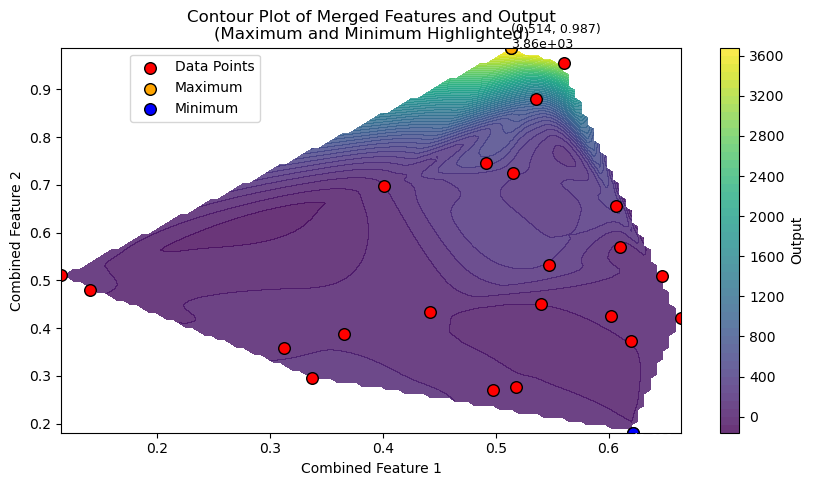

Max: 3.86e+03 at (0.5136, 0.9871)
Min: 1.13e-01 at (0.6213, 0.1808)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Ensure f1_out is 1D
f1_out = f1_out.ravel()
num_features = f1_inp.shape[1]

#############################
# Layout with GridSpec for Correlation Matrix and Scatter Plots
#############################
import matplotlib.gridspec as gridspec

# Create a figure with GridSpec: top for correlation matrix, bottom for scatter plots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # Two rows: correlation matrix and scatter plots

# --- Top: Correlation Matrix ---
ax_corr = fig.add_subplot(gs[0])
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))
correlation_matrix = np.corrcoef(data.T)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    ax=ax_corr
)
ax_corr.set_title("Correlation Matrix", fontsize=16)

# --- Bottom: Scatter Plots ---
fig_scatter, axes_scatter = plt.subplots(1, num_features, figsize=(5*num_features, 5))
for i in range(num_features):
    axes_scatter[i].scatter(f1_inp[:, i], f1_out, alpha=0.7, edgecolor="k")
    axes_scatter[i].set_xlabel(f"Feature_{i+1}")
    axes_scatter[i].set_ylabel("Target")
    axes_scatter[i].set_title(f"Feature_{i+1} vs Target")
    axes_scatter[i].grid(True)

plt.tight_layout()
plt.show()

#############################
# 3D Surface Plots for Two Feature Pairs
#############################

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import skew

# Example input data (replace with actual f1_inp and f1_out)
# f1_inp: shape (n_samples, n_features)
# f1_out: shape (n_samples,)
# Ensure f1_out is 1D
f1_out = f1_out.ravel()

def merge_features(data):
    """
    Merge features into two groups by averaging.
    Splits the columns into two halves and computes the mean of each half for each sample.
    """
    n_samples, n_features = data.shape
    # Determine splitting index (round up if odd number of features)
    split_idx = (n_features + 1) // 2  
    # First group: average of first half, second group: average of remaining
    group1 = np.mean(data[:, :split_idx], axis=1)
    group2 = np.mean(data[:, split_idx:], axis=1) if split_idx < n_features else np.zeros(n_samples)
    return group1, group2

# Merge features into two combined dimensions
x, y = merge_features(f1_inp)
z = f1_out

# Create grid points for interpolation over the range of merged features
grid_x, grid_y = np.mgrid[
    x.min():x.max():100j, 
    y.min():y.max():100j
]

# Interpolate the Z values for the grid using cubic method
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points on original data in merged space
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plotting the contour plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Combined Feature 1")
plt.ylabel("Combined Feature 2")
plt.title("Contour Plot of Merged Features and Output\n(Maximum and Minimum Highlighted)")
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))
plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")


# def plot_3d_surface(feature_idx1, feature_idx2, title):
#     # Extract two features and target
#     x = f1_inp[:, feature_idx1]
#     y = f1_inp[:, feature_idx2]
#     z = f1_out

#     # Create grid points for interpolation
#     grid_x, grid_y = np.meshgrid(
#         np.linspace(x.min(), x.max(), 100),
#         np.linspace(y.min(), y.max(), 100)
#     )

#     # Interpolate the Z values for the grid
#     grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

#     # Plotting the surface
#     fig = plt.figure(figsize=(10, 6))
#     ax = fig.add_subplot(111, projection="3d")
#      # Surface plot
#     surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap="viridis", edgecolor="none", alpha=1)

#     # Adding red dots (ensure they are plotted after the surface)
#     ax.scatter(x_dots, y_dots, z_dots, color='red', s=50, label='Red Dots')

#     # Add color bar
#     cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
#     cb.set_label("Target")

#     # Label axes and title
#     ax.set_xlabel(f"Feature {feature_idx1+1}")
#     ax.set_ylabel(f"Feature {feature_idx2+1}")
#     ax.set_zlabel("Target")
#     plt.title(title)
#     plt.legend(loc="best")
#     plt.show()




### Conclusion about input/ouput relationship
- Feature 3 has a very small correlation with the target variable, considering to remove it 
- Feature 4 has got strongest corerlation
- After merging features we now know the area expected for imporvmnet

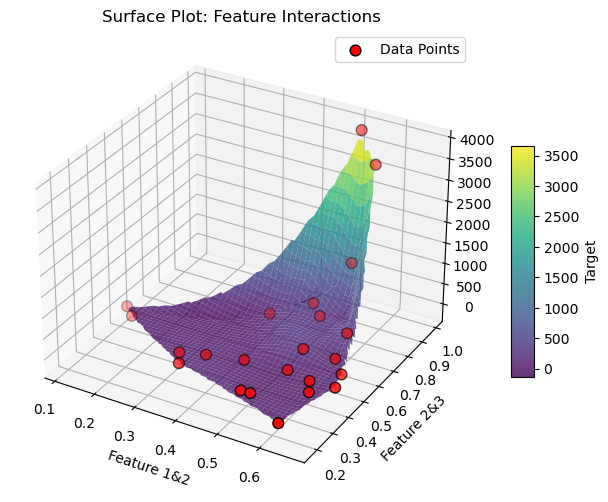

In [10]:
# x, y = DECLARED ABOVE
# z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1&2")
ax.set_ylabel("Feature 2&3")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
- Test after you have built the surrogate model, if there are future that just add noise and affect predictions 

In [11]:
# Analysing skewnes and variance 




# Bench mark model for analysis( Linear Regression)

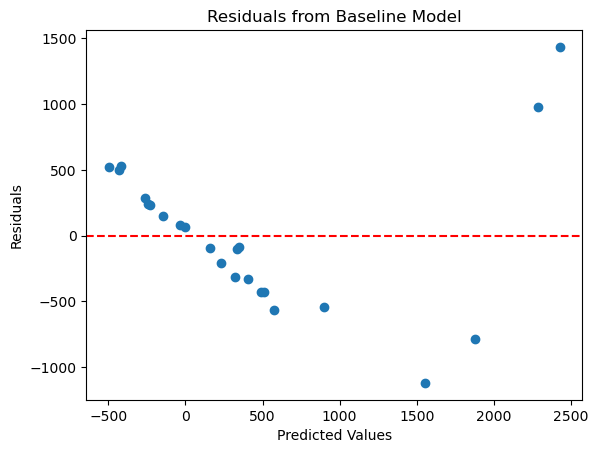

Residual Variance: 326674.167
Residual Mean: 0.000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [13]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 708928.068
Residual Variance (Noise): 326674.167
Residual Skewnes : 0.470
Signal-to-Noise Ratio (SNR): 2.170


- A high  signal variance means that the model is understanding well patterns of data
- A low residual variance is desirable, as it indicates that predictions are close to the observed values. If the surrogate model reduces residual variance, it is an improvement over the benchmark.
- Residual Skewness: Shows the symmetry of prediction errors (residuals). For benchmarking: A skewness near zero indicates balanced prediction errors, aligning with the assumption of normally distributed residuals.
- Signal-to-Noise Ratio (SNR): The ratio of signal variance to noise variance, measuring how dominant the signal is over noise. For benchmarking: A higher SNR means the model is better at distinguishing the signal from noise.

# Conclusion:
- There is a high v Residual Variance (Noise): 21446.895

# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [14]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension


amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]

(1017.6454365466644,
 array([0.24592827, 0.29347406, 0.26768742, 0.32068193]),
 [array([-0.0331138 , -0.05723729,  0.00042663, -0.01983027]),
  array([0.91553179, 1.08793066, 1.06266922, 1.09269875])])

- Start with the above Amplitude but let the optimizer refine it during training

- Start with the above Lenfthscale but let the optimizer refine it during training

- Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds

<span style="color: green;">
Strategy taken during this project is that I avoid input/output transformation to start with, and get the Log Marginal Likelihood. Then perform transformation and check the difference.
</span>


# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



In [3]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Assuming f1_out is a NumPy array or a pandas Series
f1_out_transformed = PowerTransformer(method='yeo-johnson').fit_transform(f1_out.reshape(-1, 1))

# The transformed data is now stored in f1_out_transformed
f1_out, f1_out_transformed



(array([6.44434399e+01, 1.83013796e+01, 1.12939795e-01, 4.21089813e+00,
        2.58370525e+02, 7.84343889e+01, 5.75715369e+01, 1.09571876e+02,
        8.84799176e+00, 2.33223610e+02, 2.44230883e+01, 6.44201468e+01,
        6.34767158e+01, 7.97291299e+01, 3.55806818e+02, 1.08885962e+03,
        2.88667516e+01, 4.51815703e+01, 4.31612757e+02, 9.97233189e+00,
        1.16473297e+03, 1.21188493e+02, 2.87522281e+02, 1.98066524e+03,
        5.28521436e+02, 6.59070325e+01, 2.73993040e+02, 3.34964253e+02,
        3.03509422e+00, 3.16811442e+02, 2.13695298e+03, 1.63923940e+01,
        1.47198474e+01, 7.44697895e+00, 5.40487146e+02, 1.52854400e+02,
        1.03383108e+02, 2.53166057e+02, 3.59261876e+01, 2.10925883e+00,
        3.22820434e+00, 3.26848556e+03, 3.86327186e+03, 3.50072283e+03,
        3.56761164e+03]),
 array([[-0.25086285],
        [-0.83354686],
        [-2.1499132 ],
        [-1.44542724],
        [ 0.42063636],
        [-0.15731334],
        [-0.30429336],
        [ 0.00307861]

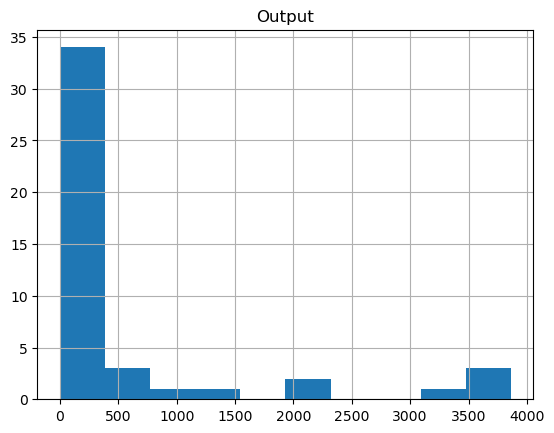

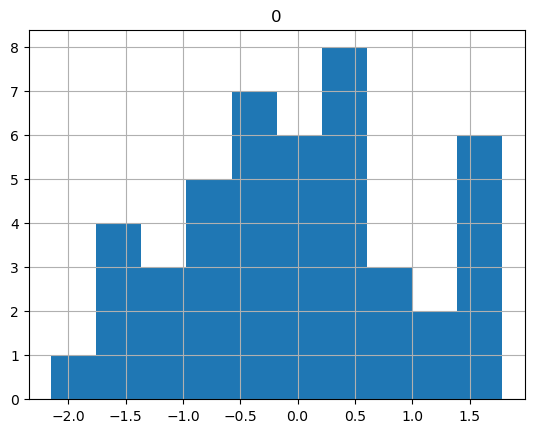

In [5]:
pd_out_tranformed = pd.DataFrame(f1_out_transformed)
pd_out.hist(),pd_out_tranformed.hist()
plt.show()

# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [4]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
# np.std(f1_inp_normalized), np.std(f1_inp)
# skew(f1_inp_normalized), skew(f1_inp)
# f1_inp_normalized
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

In [15]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm



# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                                | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_7604\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.62it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.748159
b = 0.726305
Combined Score (Variance + Skewness) = 0.164894
Final Variance: 0.087599
Final Skewness: 0.077295


In [6]:
from scipy.stats import skew
# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.516233, b=0.540033)
f1_inp, f1_inp_warped


np.var(f1_inp),skew(f1_inp), np.var(f1_inp_warped),skew(f1_inp_warped)


(0.09000577001109587,
 array([ 0.32185491, -0.29179355, -0.17112993,  0.03546648]),
 0.06196692358354032,
 array([ 0.42071066, -0.17058135, -0.06198083,  0.16951848]))

In [7]:
# SKEWNES IMPROVED/ POSITIVE RESULT

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
       dtype=object),
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
       dtype=object))

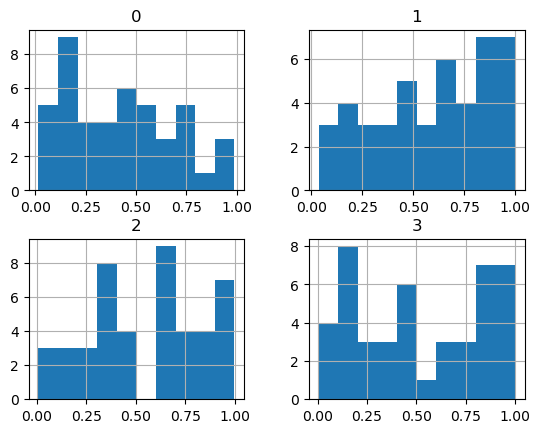

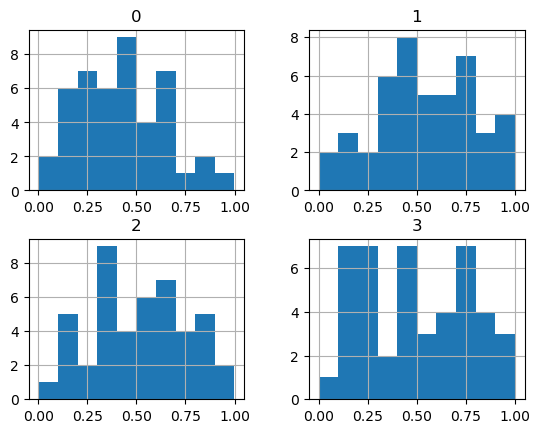

In [8]:
pd_wraped = pd.DataFrame(f1_inp_warped)
pd_inp.hist(), pd_wraped.hist() # Before and after


# ***************************** Gaussian Process****************************


In [10]:
x_final = f1_inp_warped
y_final = f1_out_transformed

# Testing Diffrent Kernels

- Inital parameters taken form the EDA 

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

# Initial parameters
amplitude_init = 7.137959461329917
length_scale_init = np.array([0.29400738, 0.30890995, 0.26161802, 0.2924121])
extended_min_bounds = np.array([-0.05695488, -0.08508379, -0.04751281, -0.01028004])
extended_max_bounds = np.array([1.0804016, 1.01092651, 1.02887706, 1.09127916])

# Define kernels and hyperparameter ranges
kernels_list = [
    RBF(length_scale=1.0),
    Matern(length_scale=1.0, nu=1.5),
    Matern(length_scale=1.0, nu=2.5),
    RationalQuadratic(length_scale=1.0, alpha=1.0)
]

# Hyperparameter grids
amplitudes = np.linspace(0.8 * amplitude_init, 1.2 * amplitude_init, 10)  # Expanded to 10 points
length_scales = np.linspace(length_scale_init.mean() * 0.5, length_scale_init.mean() * 1.5, 10)  # Wider range
alphas = np.linspace(0.5, 2.5, 10)  # For RationalQuadratic

# Fixed noise level bounds
noise_level = 1e-5
noise_bounds = (1e-6, 1e-3)

# Placeholder for results
results = []

# Total iterations for progress bar
total_iterations = len(kernels_list) * len(amplitudes) * len(length_scales) * len(alphas)
progress_bar = tqdm(total=total_iterations, desc="Optimizing Kernels")

# Define a dummy data setup for illustration (replace with actual data)
X = f1_inp # 100 samples, 4 features
y = f1_out  # Target values

# Optimization loop
for kernel in kernels_list:
    for amp in amplitudes:
        for ls in length_scales:
            if isinstance(kernel, RationalQuadratic):
                for alpha in alphas:
                    # Create kernel with specified parameters
                    tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * RationalQuadratic(length_scale=ls, alpha=alpha)
                    
                    # Initialize Gaussian Process with kernel
                    gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                    
                    # Fit and compute Log Marginal Likelihood (LML)
                    gp.fit(X, y)
                    lml = gp.log_marginal_likelihood()
                    
                    # Store results
                    results.append((kernel, amp, ls, alpha, lml))
            else:
                # Create kernel with specified parameters
                tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * kernel.clone_with_theta([ls])
                
                # Initialize Gaussian Process with kernel
                gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                
                # Fit and compute Log Marginal Likelihood (LML)
                gp.fit(X, y)
                lml = gp.log_marginal_likelihood()
                
                # Store results
                results.append((kernel, amp, ls, None, lml))
            
            # Update progress bar
            progress_bar.update(1)

progress_bar.close()

# Sort results by LML (descending) and display the best result
results.sort(key=lambda x: x[-1], reverse=True)
best_result = results[0]

print("\nBest Kernel Configuration:")
print(f"Kernel: {best_result[0]}")
print(f"Amplitude: {best_result[1]:.3f}")
print(f"Length Scale: {best_result[2]:.3f}")
if best_result[3] is not None:
    print(f"Alpha: {best_result[3]:.3f}")
print(f"Log Marginal Likelihood: {best_result[4]:.3f}")


-  Results before transformation
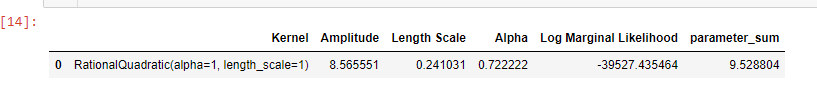

Not satisfied with the result above, I will try tarnsforming the data

-  Results AFTER input/output transformation
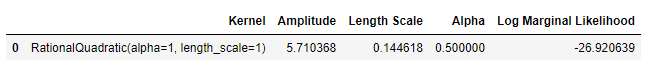

In [25]:
# Define column names for clarity
columns = ["Kernel", "Amplitude", "Length Scale", "Alpha", "Log Marginal Likelihood"]

# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=columns)

# Convert numeric columns to appropriate data types if necessary
results_df["Amplitude"] = pd.to_numeric(results_df["Amplitude"], errors='coerce')
results_df["Length Scale"] = pd.to_numeric(results_df["Length Scale"], errors='coerce')
results_df["Alpha"] = pd.to_numeric(results_df["Alpha"], errors='coerce')
results_df["Log Marginal Likelihood"] = pd.to_numeric(results_df["Log Marginal Likelihood"], errors='coerce')

# Sort DataFrame by Log Marginal Likelihood in descending order to get the best result on top
results_df.sort_values(by="Log Marginal Likelihood", ascending=False, inplace=True)

# Display the top of the sorted DataFrame with explanations
print("\nBest Kernel Configurations:")
results_df.head()




Best Kernel Configurations:


,Kernel,Amplitude,Length Scale,Alpha,Log Marginal Likelihood
0,"RationalQuadratic(alpha=1, length_scale=1)",5.710368,0.144618,0.500000,-26.920639
1,"RationalQuadratic(alpha=1, length_scale=1)",5.710368,0.176756,0.500000,-26.920639
2,"RationalQuadratic(alpha=1, length_scale=1)",5.710368,0.305306,2.055556,-26.920639
4,"RationalQuadratic(alpha=1, length_scale=1)",5.710368,0.241031,2.277778,-26.920639
5,"RationalQuadratic(alpha=1, length_scale=1)",5.710368,0.337443,1.388889,-26.920639



### Rational Quadritic Kernel is having the best score so far
- The good news is with this kernel we do not need to standarise the data as per the below instruction 
- Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000),

In [40]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from tqdm import tqdm

# Refined parameter grid based on the new best kernel
param_grid = {
    "scaling_factor": np.linspace(0.8, 1.0, 5),  # Narrow range around 0.934
    "rbf_length_scale": np.linspace(0.6, 0.7, 5),  # Focus around 0.654
    "exp_length_scale": np.linspace(0.07, 0.09, 5),  # Narrower range around 0.0792
    "exp_periodicity": np.linspace(0.8, 0.85, 5),  # Refined around 0.836
    "noise_level": np.linspace(4e-4, 6e-4, 5),  # Focus around 0.000505
}

# Store the best kernel and LML
best_lml = -np.inf
best_kernel = None

# Calculate the total number of iterations
total_iterations = (
    len(param_grid["scaling_factor"]) *
    len(param_grid["rbf_length_scale"]) *
    len(param_grid["exp_length_scale"]) *
    len(param_grid["exp_periodicity"]) *
    len(param_grid["noise_level"])
)

# Loop through the refined parameter grid with tqdm for progress tracking
with tqdm(total=total_iterations, desc="Optimizing Kernel Parameters") as pbar:
    for scaling_factor in param_grid["scaling_factor"]:
        for rbf_length_scale in param_grid["rbf_length_scale"]:
            for exp_length_scale in param_grid["exp_length_scale"]:
                for exp_periodicity in param_grid["exp_periodicity"]:
                    for noise_level in param_grid["noise_level"]:
                        # Define the kernel with the current parameters
                        kernel = (
                            C(scaling_factor**2, (1e-3, 1e3)) *
                            (RBF(length_scale=rbf_length_scale, length_scale_bounds=(0.05, 1.1)) +
                             ExpSineSquared(length_scale=exp_length_scale,
                                            periodicity=exp_periodicity,
                                            length_scale_bounds=(0.05, 1.0),
                                            periodicity_bounds=(0.5, 2.0))) +
                            WhiteKernel(noise_level=noise_level, noise_level_bounds=(1e-12, 1e-1))
                        )
                        
                        # Initialize and fit the Gaussian Process
                        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
                        gp.fit(f1_inp, f1_out)
                        
                        # Get the Log Marginal Likelihood
                        lml = gp.log_marginal_likelihood()
                        
                        # Update the best kernel if the current LML is higher
                        if lml > best_lml:
                            best_lml = lml
                            best_kernel = gp.kernel_
                        
                        # Update the progress bar
                        pbar.update(1)

# Output the best kernel and LML
print("\n=== Best Kernel and LML ===")
print("Best Kernel:", best_kernel)
print("Best Log Marginal Likelihood (LML):", best_lml)


Optimizing Kernel Parameters:  20%|██████████▊                                          | 637/3125 [01:20<05:43,  7.25it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernel Parameters:  20%|██████████▊                                          | 638/3125 [01:20<05:51,  7.08it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernel Parameters:  70%|████████████████████████████████████▎               | 2181/3125 [06:11<03:21,  4.69it/s]C:\Users\


=== Best Kernel and LML ===
Best Kernel: 0.863**2 * RBF(length_scale=0.655) + ExpSineSquared(length_scale=0.0744, periodicity=0.838) + WhiteKernel(noise_level=0.000602)
Best Log Marginal Likelihood (LML): -22.83719720161939


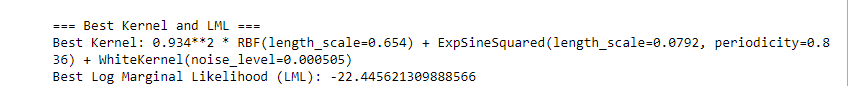

In [9]:
x_final = f1_inp_warped
y_final = f1_out_transformed

# - Final Kernel 

In [30]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared,RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

# Define the composite kernel with the provided data
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel as C

kernel = (
    C(0.963**2, (1e-3, 1e1)) *  # Scaling factor squared
    (
        RBF(length_scale=0.655, length_scale_bounds=(0.05, 1.1)) +  # RBF kernel with length scale
        ExpSineSquared(
            length_scale=0.0744,  # Exponentiated Sine Squared kernel length scale
            periodicity=0.838,  # Periodicity of the sinusoidal kernel
            length_scale_bounds=(0.09, 1.0),  # Bounds for length scale
            periodicity_bounds=(0.5, 4.0)  # Bounds for periodicity
        )
    ) +
    WhiteKernel(noise_level=0.0602, noise_level_bounds=(1e-12, 9e-1))  # White kernel for noise
)


# kernel = ConstantKernel(5.710368, (1e-3, 1e3)) * RationalQuadratic(
#     length_scale=0.144618,   # Updated length scale from the data
#     alpha=5,              # Updated alpha from the data
#     length_scale_bounds=(0.05, 1.1),  # Bounds for length scale
#     alpha_bounds=(1e-2, 4)          # Adjusted bounds for alpha based on data
# ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1))

# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Fit the GP model to the provided data

gp.fit(x_final, y_final)

# Output the optimized kernel and Log Marginal Likelihood
print("Optimized Kernel:", gp.kernel_)
print("Log Marginal Likelihood (LML):", gp.log_marginal_likelihood()) #comebacktothis


Optimized Kernel: 0.753**2 * RBF(length_scale=0.705) + ExpSineSquared(length_scale=0.778, periodicity=1.62) + WhiteKernel(noise_level=1.62e-10)
Log Marginal Likelihood (LML): -43.050311508058485


# Final Version 

In [25]:

import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from scipy.interpolate import griddata
from pymoo.core.problem import Problem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RationalQuadratic, WhiteKernel

class HEBOOptimizer:
    def __init__(self, bounds, initial_X=None, initial_y=None,
                 beta=2.5, xi=1.0, epsilon=0.1, random_state=None, noise_factor=0.01):

        self.bounds = np.array(bounds)
        self.dim = len(bounds)
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)
        
        # Initialize data storage
        self.X = initial_X 
        self.y = initial_y 
        noise_level = max(noise_factor * np.var(x_final), 1e-8)
        # Configure GP kernel
        self.kernel = (
            C(1.0, (1e-14, 1e3)) *  # ConstantKernel (scale)
            (
                RBF(length_scale=2,  # Large length scale for feature 2 (ignored)
                    length_scale_bounds=[(3.43e-7, 1.0)])
                +
                ExpSineSquared(length_scale=0.5, periodicity=2,  # Single length scale for all
                               length_scale_bounds=(3.43e-3, 4.0),
                               periodicity_bounds=(1e-2, 1e1))
            )
            + WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-6, 0.5))  # Noise
        )
    def _fit_gp(self, kernel=None):
        if kernel is None:
            kernel = self.kernel  # n_restarts_optimizer=10,
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False,
            random_state=self.rng
        )
        gp.fit(self.X, self.y)
        return gp



    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                mu, sigma = self.gp.predict(X, return_std=True)
                
                # Correct way to access noise level
                noise_var = self.gp.kernel_.get_params().get('k2__noise_level', 1e-9)
                
                mu_adj = mu + self.xi * noise_var  # HEBO's stochastic mean
                
                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu_adj - self.best) / sigma
                
                ei = (mu_adj - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu_adj + self.beta * sigma
                
                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y) == 0:
            return self._random_sample()
        
        problem = MACEProblem(gp, self.bounds, np.max(self.y), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem, algorithm, ("n_gen", 100))
        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        # Fit GP with current data
        gp = self._fit_gp()
        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y = np.concatenate([self.y, np.atleast_1d(y_new)])
    

## Change this depending if the input is normalised/tranformed or not
def get_dynamic_bounds(x_final):
    return [(0, 1) if np.all((x >= 0) & (x <= 1)) else (x.min(), x.max()) for x in x_final.T]

bounds = get_dynamic_bounds(x_final)
#bounds = [[0.0, 0.24,],[0.72,0.98],[0.78,0.99],[0.82, 0.9]]

hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=x_final,
    initial_y=y_final,
    # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    beta = 1.5,  # Expands search boundaries by considering high-uncertainty areas

    # Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    xi = 1, # Increases exploration in noisy areas, expanding search range

    # Exploration probability: Higher ε increases random sampling
    epsilon = 0.1 # Ad
)

# 3. Get next candidate point
next_point = hebo.suggest_next_point().flatten()
#next_point = hebo.suggest_next_point().reshape(-1)

# next z is predicited value at the inputs found from nextpoint, we use gausian
# process that we had trained above 
next_z = hebo._fit_gp().predict(next_point.reshape(1, -1))[0]
print(f"Next point to evaluate: {next_point}")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

gp = hebo._fit_gp()
y_pred, y_std = gp.predict(X_test, return_std=True)

# Compute Mean Squared Error
mse = np.mean((y_pred - y_test) ** 2)



# Print information about the points
# print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.6f}) at output, {np.max(y_final)}")
# print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.6f})")
# #print(f"Last Added Point: {last_z:.8e} at (x1={last_x:.6f}, x2={last_y:.6f})")
print(f"Mean Squared Error (MSE): {mse}")
print("------------------------------------------------------------------------------------------------------------")
print(f"Next Best Point (MACE): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f}, x3={next_point[2]:.6f} , x4={next_point[3]:.6f} )")

Next point to evaluate: [0.20099829 0.98790509 0.99999996 0.94578155]
Mean Squared Error (MSE): 2.3083584678265616
------------------------------------------------------------------------------------------------------------
Next Best Point (MACE): 1.73082906e+00 at (x1=0.200998, x2=0.987905, x3=1.000000 , x4=0.945782 )


In [26]:

def kumaraswamy_inverse_warp(Y, a, b):
    # Ensure Y is a numpy array
    Y = np.asarray(Y)
    # Perform the transformation
    values = (1 - (1 - Y) ** (1/b)) ** (1/a)
    # Format each value as a string with six decimal places
    formatted = '-'.join(f"{v:.6f}" for v in values.tolist())
    # Print the requested format
    print(f"The requested format for submitting the queries is {formatted}")
    return formatted

next_point_original = kumaraswamy_inverse_warp(next_point,  a=0.516233, b=0.540033)
next_point_original
next_point_original
#If there is an transformation 
next_point

The requested format for submitting the queries is 0.123715-0.999455-1.000000-0.991246


array([0.20099829, 0.98790509, 0.99999996, 0.94578155])

In [22]:
# Changed to the below for mor explotation 

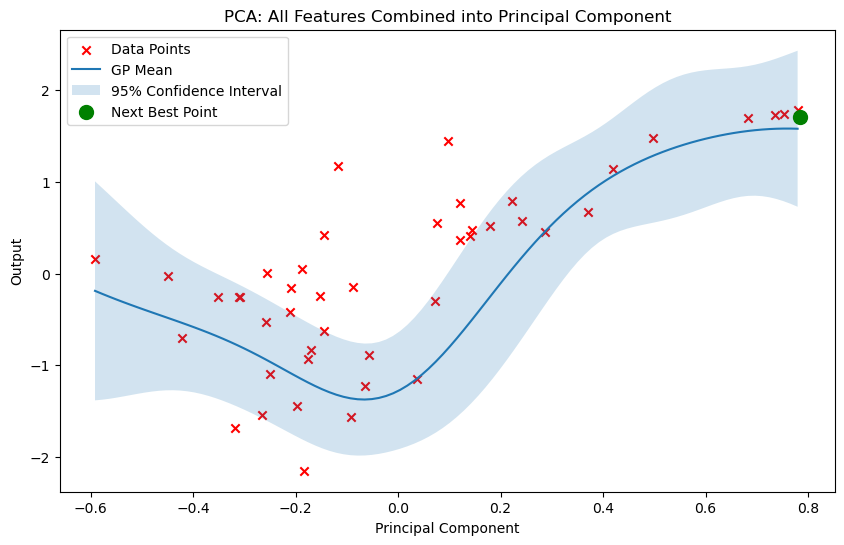

Next best point (4D): [0.21709259 0.99241882 0.99999467 0.94974666]
Predicted value at next best point: 1.710463


In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




# test_kernel = (
#             C(1.0, (1e-14, 1e3)) *  # ConstantKernel (scale)
#             (
#                 RBF(length_scale=2,  # Large length scale for feature 2 (ignored)
#                     length_scale_bounds=[(3.43e-7, 1.0)])
#                 +
#                 ExpSineSquared(length_scale=0.5, periodicity=2,  # Single length scale for all
#                                length_scale_bounds=(3.43e-3, 4.0),
#                                periodicity_bounds=(1e-2, 1e1))
#             )
#             + WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-6, 0.5))  # Noise
#         )




# # # Fit GP model
# hebo.kernel = test_kernel  # e.g., RBF(...) + WhiteKernel(...)

# Apply PCA to reduce to 1D
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Create a grid along the PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

gp = hebo._fit_gp()

# Get next best point from HEBO
next_point = hebo.suggest_next_point().flatten()
# GP predictions along the grid
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% Confidence Interval')
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=100, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")


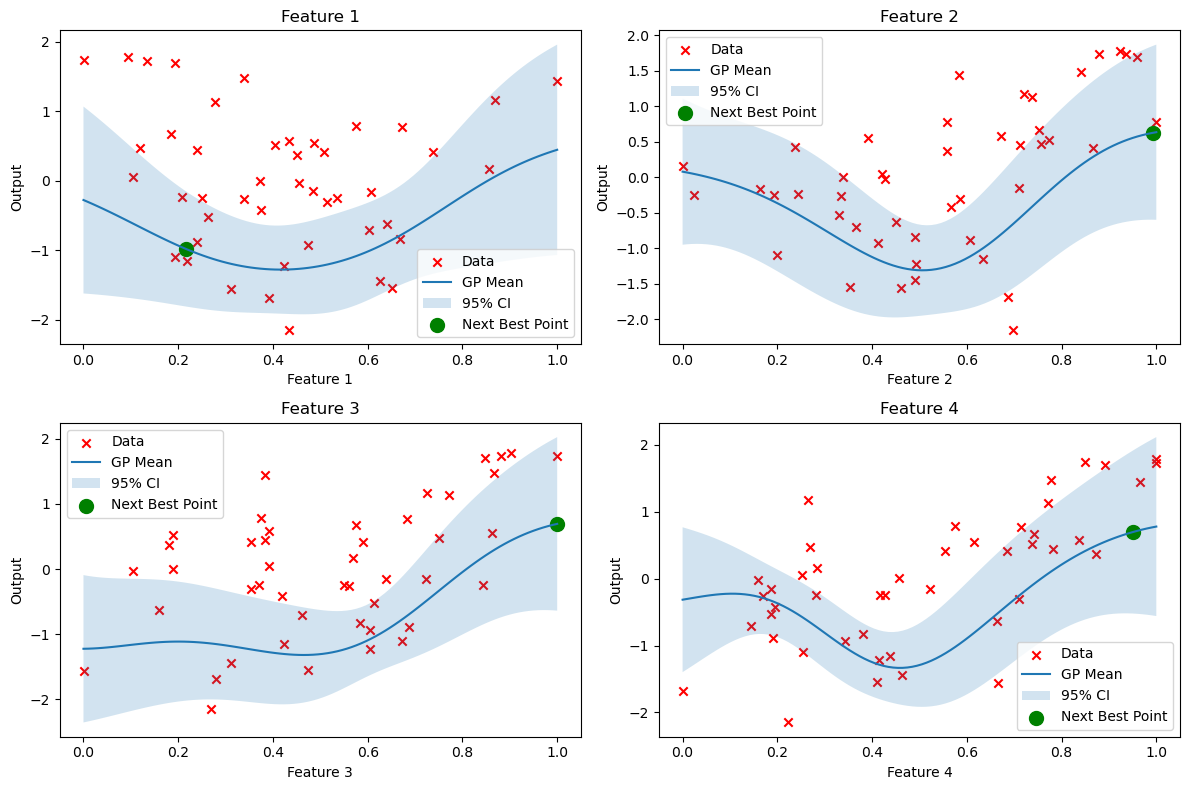

Next best point (4D): [0.21709259 0.99241882 0.99999467 0.94974666]
Predicted mean at next best point: 1.7105
Predicted std at next best point: 0.5071


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate feature means and set up grid
means_other_features = np.mean(x_final, axis=0)
grid = np.linspace(0, 1, 100)

# Predict at the next best point
next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)

# Plot for each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.ravel()):
    # Prepare grid points for this feature
    X_plot = np.tile(means_other_features, (100, 1))
    X_plot[:, i] = grid
    mean_pred, std_pred = gp.predict(X_plot, return_std=True)

    # Plot data, GP mean, and confidence interval
    ax.scatter(x_final[:, i], y_final, color='r', marker='x', label='Data')
    ax.plot(grid, mean_pred, label='GP Mean')
    ax.fill_between(grid, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% CI')
    
    # Highlight next best point
    X_next = means_other_features.copy()
    X_next[i] = next_point[i]
    y_next_dim = gp.predict(X_next.reshape(1, -1))[0]
    ax.scatter(next_point[i], y_next_dim, color='green', s=100, marker='o', label='Next Best Point')

    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('Output')
    ax.legend()

plt.tight_layout()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted mean at next best point: {next_mean[0]:.4f}")
print(f"Predicted std at next best point: {next_std[0]:.4f}")


In [61]:
0.015508-0.986277-0.999610-0.942830

-2.9132089999999997